# Create a map of the geology and the total-field anomaly data

Use geology shapefiles from SGB and the processed total-field anomaly data (see notebook `real-data-preparation.ipynb`) to generate a simplified geologic map.

In [1]:
import pygmt
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import numpy as np
import verde as vd
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Load the shapefiles

Read in the geologic map information from the shapefiles and convert all coord

In [3]:
fig_dir = Path("..") / "paper" / "figures"
data_dir = Path("..") / "data"
shape_dir = data_dir / "raw" / "shapefiles"
processed_dir = data_dir / "processed"

In [4]:
dikes = gpd.read_file(shape_dir / "dikes_cut.shp")
dikes = dikes.to_crs("EPSG:4326")
dikes

ESPESSURA                              DATA          EQUIPE CARDENETA  \
0         0.0                               NaN             NaN       NaN   
1         0.0                               NaN             NaN       NaN   
2         0.0                               NaN             NaN       NaN   
3        33.0                               NaN     Tiago Dutra       NaN   
4         0.0                               NaN             NaN       NaN   
..        ...                               ...             ...       ...   
58        0.0  sexta-feira, 20 de julho de 2001   Julio Almeida    JA-033   
59        0.0                               NaN             NaN       NaN   
60      100.0                               NaN  Sérgio Valente       NaN   
61        0.0                               NaN             NaN       NaN   
62        0.0                               NaN             NaN       NaN   

                          FOLHA  \
0     Saquarema (SF.23-Z-B-V-4)   
1                           NaN   
2                           NaN   
3                     Cabo Frio   
4                           NaN   
..                          ...   
58            Trajano de Moraes   
59                          NaN   
60                  Duas Barras   
61                          NaN   
62  Renascença (SF.24-V-C-IV-3)   

                                           DESC_LOCAL           DOMINIO  \
0                                                 NaN               NaN   
1                                                 NaN               NaN   
2                                                 NaN               NaN   
3                    Em frente ao Ed. Portal do Cabo.               NaN   
4                                                 NaN               NaN   
..                                                ...               ...   
58                                  Trajano de Moraes  Domínio Costeiro   
59                                                NaN               NaN   
60  Estrada RJ-148, sentido Murinelli, próximo a c...               NaN   
61                                                NaN               NaN   
62                                                NaN               NaN   

           UNID_ENCAI TIPO_ESTRU  AZIMUTE_EN  ... MAT_2 LAB_2  SUITE  \
0                   *        NaN           0  ...   NaN   NaN    NaN   
1                   *        NaN           0  ...   NaN   NaN    NaN   
2   Ilha do Cabo Frio        NaN           0  ...   NaN   NaN    NaN   
3    Região dos Lagos        NaN           0  ...   NaN   NaN    NaN   
4    Forte São Mateus        NaN           0  ...   NaN   NaN    NaN   
..                ...        ...         ...  ...   ...   ...    ...   
58                NaN        NaN           0  ...   NaN   NaN    NaN   
59                NaN        NaN           0  ...   NaN   NaN    NaN   
60                NaN        NaN           0  ...   NaN   NaN    NaN   
61                NaN        NaN           0  ...   NaN   NaN    NaN   
62                NaN        NaN           0  ...   NaN   NaN    NaN   

    INCLINAC_1  AZIMUTE  AZIMUT  DIRECAO EXTENDIDOS      CLASSE_DIQ  \
0            0        0   234.0       SW        NaN    Rocha Básica   
1            0        0    62.0      ENE        NaN  Rocha alcalina   
2            0        0   135.0       SE        NaN  Rocha alcalina   
3            0      130    57.0       NE        NaN  Rocha alcalina   
4            0        0    59.0       NE        NaN    Rocha Básica   
..         ...      ...     ...      ...        ...             ...   
58           0        0    64.0      ENE        NaN    Rocha Básica   
59           0        0   208.0      SSW        NaN    Rocha Básica   
60           0        0   208.0      SSW         ok    Rocha Básica   
61           0        0   233.0       SW         ok    Rocha Básica   
62           0        0    46.0       NE          *    Rocha Básica   

                                       

In [5]:
geology = gpd.read_file(shape_dir / "geology_cut.shp")
geology = geology.to_crs("EPSG:4326")
geology

SIGLA_UNID                       NOME_UNIDA    HIERARQUIA  \
0              Q2li             Depósitos litorâneos  Não definida   
1              Q2pm  Depósitos de pântanos e mangues  Não definida   
2             PP3rl                 Região dos Lagos      Complexo   
3             PP3rl                 Região dos Lagos      Complexo   
4             NP3bp                           Búzios       Unidade   
...             ...                              ...           ...   
1068  NP3_gamma_2co                         Cordeiro         Suíte   
1069       NP12iteu           Italva - Euclidelândia       Unidade   
1070  NP3_gamma_2co                         Cordeiro         Suíte   
1071         NPrpaa          Raposos - Arcádia Areal       Unidade   
1072         NPrpaa          Raposos - Arcádia Areal       Unidade   

                                              LITOTIPO1  \
0                                         Areia, Argila   
1                                                 Areia   
2                         Metagranodiorito, Metagranito   
3                         Metagranodiorito, Metagranito   
4     Gnaisse, Xisto, Rocha calcissilicática, Kinzigito   
...                                                 ...   
1068                                                NaN   
1069                                  Muscovita gnaisse   
1070                                                NaN   
1071                            Granada-biotita gnaisse   
1072                            Granada-biotita gnaisse   

                                              LITOTIPO2            CLASSE_RX1  \
0                                                   NaN  Material superficial   
1                                                   NaN  Material superficial   
2                                                   NaN           Metamórfica   
3                                                   NaN           Metamórfica   
4                                 Anfibolito, Quartzito           Metamórfica   
...                                                 ...                   ...   
1068                                                NaN                 Ígnea   
1069                                                NaN           Metamórfica   
1070                                                NaN                 Ígnea   
1071  Quartzito, Rocha calcissilicática, Rocha metau...           Metamórfica   
1072  Quartzito, Rocha calcissilicática, Rocha metau...           Metamórfica   

     COD_DOM                                            DOMINIO COD_UNIGEO  \
0         DC  DOMÍNIO DOS SEDIMENTOS CENOZOICOS INCONSOLIDAD...       DCmc   
1         DC  DOMÍNIO DOS SEDIMENTOS CENOZOICOS INCONSOLIDAD...        DCl   
2      DCGR3  DOMÍNIO DOS COMPLEXOS GRANITOIDES INTENSAMENTE...  DCGR3salc   
3      DCGR3  DOMÍNIO DOS COMPLEXOS GRANITOIDES INTENSAMENTE...  DCGR3salc   
4     DCGMGL  DOMÍNIO DOS COMPLEXOS GNAISSICO-MIGMATÍTICOS E...  DCGMGLgnp   
...      ...                                                ...        ...   
1068   DCGR2      DOMÍNIO DOS COMPLEXOS GRANITOIDES DEFORMADOS.   DCGR2pal   
1069  DCGMGL  DOMÍNIO DOS COMPLEXOS GNAISSICO-MIGMATÍTICOS E...  DCGMGLgnp   
1070   DCGR2      DOMÍNIO DOS COMPLEXOS GRANITOIDES DEFORMADOS.   DCGR2pal   
1071  DCGMGL  DOMÍNIO DOS COMPLEXOS GNAISSICO-MIGMATÍTICOS E...  DCGMGLgnp   
1072  DCGMGL  DOMÍNIO DOS COMPLEXOS GNAISSICO-MIGMATÍTICOS E...  DCGMGLgnp   

                                                 UNIGEO  ...  \
0     Ambiente marinho costeiro ? Predomínio \nde se...  ...   
1     Ambiente lagunar ? Predomínio de sedimentos ar...  ...   
2     Séries graníticas subalcalinas: calcialcalinas...  ...   
3     Séries graníticas subalcalinas: calcialcalinas...  ...   
4                           Migmatitos indiferenciados.  ...   
...                                                 ...  ...   
1068  Granitoides peraluminosos.\nEx.: Sienogranitos...  ...   
1069                        Migmatito

Categorize the different rock types into broader geologic units.

In [6]:
def categorize_lithotypes(sigla):
    if sigla.startswith(("PP3rl", "NP3bp")):
        # PP3rl --> Granitoides de Arco Magmático Orosiniano
        # NP3bp --> Paragnaisses
        return "CBT"  # Cabo Frio Domain
    elif sigla.startswith(("NP12itma", "NP12iteu")):
        # Bacias de Margem Passiva (paragnaisses)
        return "IG"  # Italva group
    elif sigla.startswith("NPsf"):
        # Bacias de Margem Ativa (paragnaisses)
        return "SFG"  # São Fidelis group
    elif sigla.startswith("NP23"):
        # Granitoides de Arco Magmático (paragnaisses)
        return "RNC"  # Rio Negro complex
    elif sigla.startswith("NP3_gamma"):
        # Granitoides syn-colisionais (Orogenese Rio Doce)
        return "RDO"  # Rio Doce orogeny
    elif sigla.startswith("C_cortado_4O1"):
        # Plutons pós-colisionais (Suíte Nova Friburgo)
        return "PCP"  # Post-collisional plutons
    elif sigla.startswith("Q"):
        # Depósitos Quaternários
        return "Q"
    elif sigla.startswith("K2"):
        # Alkaline intrusions
        return "K2"
    else:
        return "IG"

Apply the filter to the geology to create a column of the geologic unit symbol.

In [7]:
geology["category"] = geology["SIGLA_UNID"].apply(categorize_lithotypes)

## Load the magnetic data

Lead the processed magnetic data from the CSV file.

In [8]:
data = pd.read_csv(processed_dir / "rio-de-janeiro-magnetic.csv")
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number  \
0 -42.640141 -22.290868                  -16.56      151.49         2800   
1 -42.640126 -22.291738                  -43.47      162.46         2800   
2 -42.640111 -22.292608                  -65.38      170.69         2800   
3 -42.640095 -22.293493                  -74.29      173.43         2800   
4 -42.640080 -22.294363                  -67.20      170.08         2800   

      easting_m    northing_m  geometric_height_m  deriv_up  deriv_east  \
0 -4.393933e+06 -2.342247e+06         1409.274167  0.191042    0.017813   
1 -4.393932e+06 -2.342343e+06         1444.244000  0.134331    0.025458   
2 -4.393930e+06 -2.342440e+06         1418.474000  0.095536    0.036430   
3 -4.393929e+06 -2.342538e+06         1368.214000  0.038965    0.052054   
4 -4.393927e+06 -2.342634e+06         1362.864000 -0.050256    0.063335   

   deriv_north  
0    -0.096147  
1    -0.116888  
2    -0.151500  
3    -0.195592  
4    -0.179653

Get the data region to use later on.

In [9]:
region = vd.get_region((data.longitude, data.latitude))

## Load topography to use as shading

Get an Earth relief dataset from [PyGMT](https://www.pygmt.org/latest/api/generated/pygmt.datasets.load_earth_relief.html#pygmt.datasets.load_earth_relief) to use as hillshading for the geologic map.

In [10]:
topography = pygmt.datasets.load_earth_relief(
    resolution="01s",
    region=region,
).rename({"lon": "longitude", "lat": "latitude"})
topography

<xarray.DataArray 'z' (latitude: 2176, longitude: 2671)> Size: 46MB
array([[349.        , 368.        , 379.        , ..., -27.19939613,
        -27.25863838, -27.31640625],
       [345.        , 364.        , 383.        , ..., -27.16191673,
        -27.22043228, -27.27752876],
       [350.        , 367.        , 381.        , ..., -27.12260818,
        -27.18054581, -27.23712349],
       ...,
       [375.        , 365.        , 355.        , ..., 498.        ,
        494.        , 486.        ],
       [375.        , 365.        , 358.        , ..., 511.        ,
        505.        , 497.        ],
       [370.        , 362.        , 354.        , ..., 523.        ,
        514.        , 508.        ]])
Coordinates:
  * latitude   (latitude) float64 17kB -22.6 -22.6 -22.6 ... -22.0 -22.0 -22.0
  * longitude  (longitude) float64 21kB -42.64 -42.64 -42.64 ... -41.9 -41.9
Attributes:
    Conventions:       CF-1.7
    title:             
    history:           gmt grdblend @earth_relief_01s_g/ -R-42.64166666666667...
    description:       IGPP Earth relief
    long_name:         z
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

## Load the outline of Brazil

Use this to make the inset map to show the location of the survey area.

In [11]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
brazil = world[world.name == "Brazil"]

## Make a figure for the paper

Create the geologic and magnetic data map with PyGMT to use in the paper. This is a bit of a complicated figure because the geology legend is made manually.

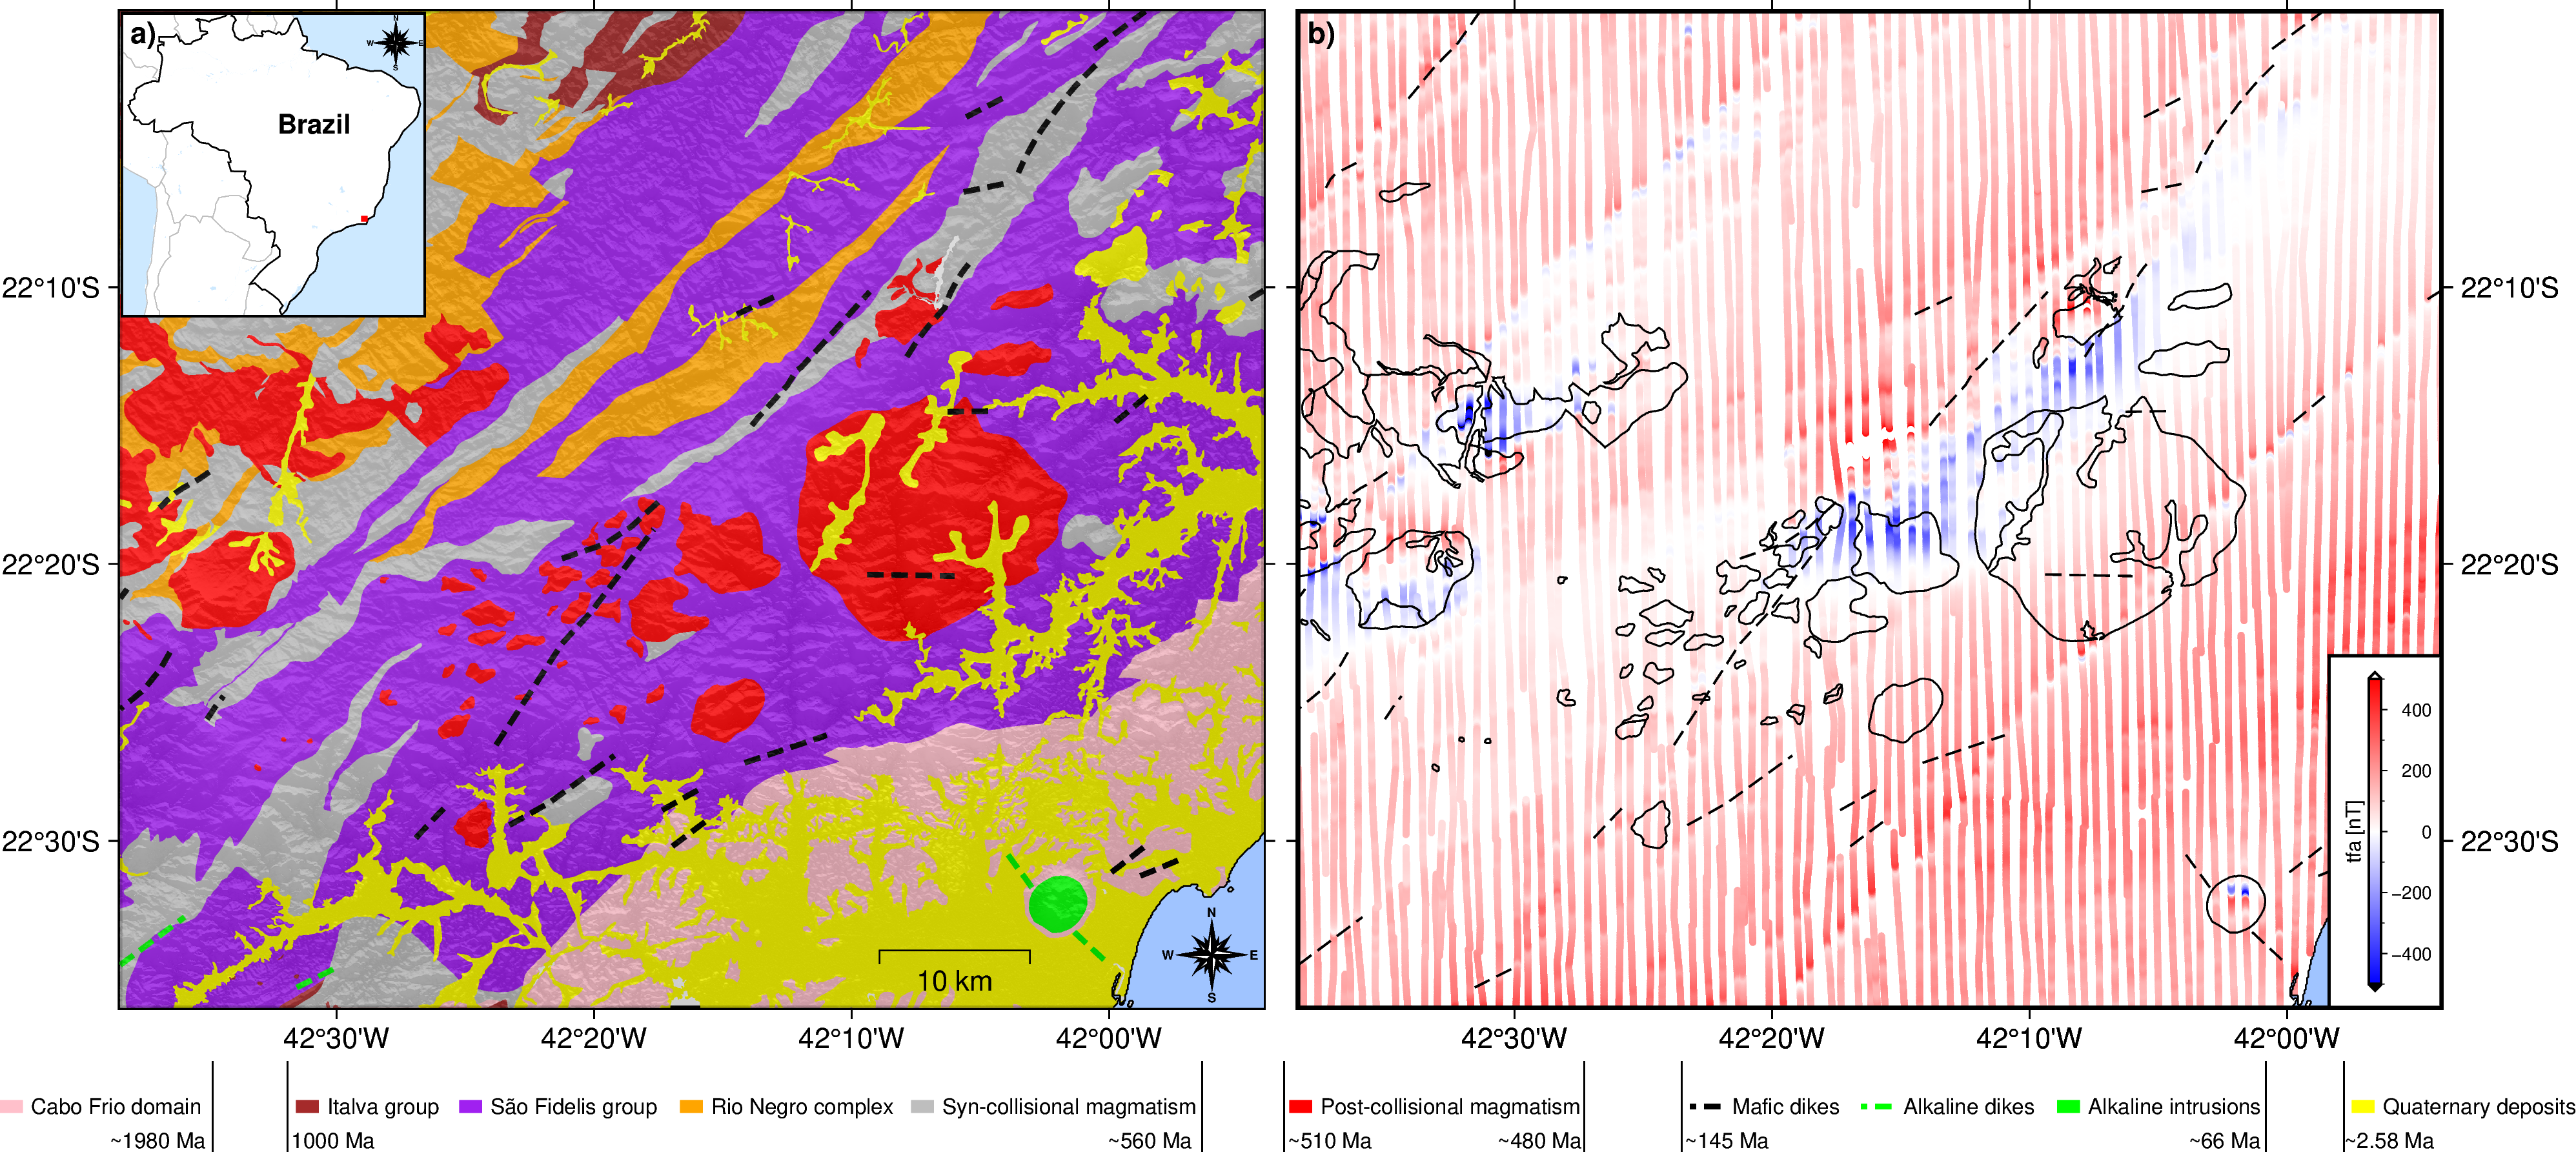

In [12]:
fig = pygmt.Figure()
# Criar os subplots: 1 linha e 2 colunas
with fig.subplot(nrows=1, ncols=2, figsize=("30c", "15c")):

    # Primeiro subplot: Mapa com geologia e intrusões
    with fig.set_panel(panel=0):  # Primeiro subplot
        pygmt.config(MAP_FRAME_TYPE="plain", MAP_GRID_PEN_PRIMARY=0.5)
        frame = ["WSne", "xa", "ya"]
        fig.basemap(region=region, projection="M15c", frame=frame)

        # Plotando Cabo Frio terrane
        pos = -7.5
        category, color, label = "CBT", "pink", "Cabo Frio domain"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")
        pos = -7.0
        diff = 3.0
        # Plotando Paragneisses (Italva group)
        pos += diff
        category, color, label = "IG", "brown", "Italva group"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 2.5
        # Plotando Paragneisses (São Fidelis group)
        pos += diff
        category, color, label = "SFG", "purple", "São Fidelis group"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 3.0
        # Plotando Orthognaisses (Rio Negro complex)
        pos += diff
        category, color, label = "RNC", "orange", "Rio Negro complex"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 3.5
        # Plotando Syn-collisional magmatism
        pos += diff
        category, color, label = "RDO", "gray", "Syn-collisional magmatism"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 5.0
        # Plotando Post-collisional magmatism
        pos += diff
        category, color, label = "PCP", "red", "Post-collisional magmatism"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 9.5
        # Plotando Alkaline intrusions
        pos += diff
        category, color, label = "K2", "green", "Alkaline intrusions"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 4
        # Plotando Quaternary sediments
        pos += diff
        category, color, label = "Q", "yellow", "Quaternary deposits"
        file = geology[geology["category"] == category]
        fig.plot(data=file, fill=color, label=label, projection="M15c")
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = -9.2
        # Plotando o dique da Serra do Mar
        pos += diff
        category, color, label = "Rocha Básica", "black", "Mafic dikes"
        file = dikes[dikes["CLASSE_DIQ"] == category]
        file = file[file.geometry.notnull()]  # Certifica-se de que há geometria válida
        fig.plot(data=file, pen=f"2p,{color},6_3:0p", projection="M15c", label=label)
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        diff = 2.4
        # Plotando os diques Alcalinos
        pos += diff
        category, color, label = "Rocha alcalina", "green", "Alkaline dikes"
        file = dikes[dikes["CLASSE_DIQ"] == category]
        file = file[file.geometry.notnull()]  # Certifica-se de que há geometria válida
        fig.plot(data=file, pen=f"2p,{color},6_3:0p", projection="M15c", label=label)
        with pygmt.config(FONT_ANNOT="8p"):
            fig.legend(position=f"jTC+o{pos}c/16c")

        # # Adicionar relevo
        fig.grdimage(
            topography,
            projection="M15c",
            cmap="gray",
            frame=frame,
            shading="+a-345",
            transparency=80,
        )
        # Adicionar a cor do oceano
        fig.coast(
            shorelines="1/0.5",
            water="#A0C4FF",
            map_scale="g-42.1/-22.57+w10k",
            projection="M15c",
        )
        fig.basemap(rose="jBR+w0.85c+f3+l", projection="M15c")
        with fig.inset(position="jTL+w4.0c+o0.01c/0.01c", margin=0):

            fig.basemap(region=[-75, -34, -34, 5], frame=True)

            colfill = "white"
            fig.coast(
                region=[-75, -34, -34, 5],
                land="white",
                resolution="h",
                frame=["WSne", "xa", "ya"],  #'a',
                water="#CDE9FF",  # "#A0C4FF"
                # projection="M15c"
            )

            fig.plot(data=world, pen="0.25p,gray")
            fig.plot(data=brazil, pen="0.5p,black")

            x = [region[0], region[1], region[1], region[0], region[0]]
            y = [region[2], region[2], region[3], region[3], region[2]]

            fig.plot(
                x=x,  # Coordenadas x do quadrado
                y=y,  # Coordenadas y do quadrado
                pen="0.2p,red",  # Define a cor e espessura da borda do quadrado
                fill="red",  # Preenchimento vazio para apenas contornar
            )

            fig.text(text="Brazil", x=-49, y=-10, font="10p,Helvetica-Bold,black")
            fig.basemap(rose="jTR+w0.5c+f3+l", frame=True)

    fig.text(
        text="    ______",
        x=-42.58,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text="~1980 Ma", x=-42.615, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-42.530,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" 1000 Ma", x=-42.500, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.920,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~560 Ma", x=-41.955, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.865,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~510 Ma", x=-41.835, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.665,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~480 Ma", x=-41.695, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.600,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~145 Ma", x=-41.570, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.210,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text="  ~66 Ma", x=-41.240, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="    ______",
        x=-41.158,
        y=-22.66,
        font="10p,Helvetica-Bold,black",
        angle=90,
        no_clip=True,
    )
    fig.text(
        text=" ~2.58 Ma", x=-41.128, y=-22.67, font="8p,Helvetica,black", no_clip=True
    )

    fig.text(
        text="a)",
        x=-42.625,
        y=-22.013,
        font="11p,Helvetica-Bold,black",
        projection="M15c",
    )

    with fig.set_panel(panel=1):  # Segundo subplot
        frame = ["wSnE", "xa", "ya"]
        pygmt.config(MAP_FRAME_TYPE="plain")
        fig.basemap(region=region, projection="M15c", frame=frame)

        pygmt.makecpt(cmap="polar", series=[-500, 500])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            fill=data.total_field_anomaly_nT,
            cmap=True,
            style="c2.5p",
            # style="h0.15c",
            projection="M15c",
            # frame=frame,
        )

        categories = ["PCP", "K2"]
        for category in categories:
            file = geology[geology["category"] == category]
            fig.plot(data=file, pen=f"0.6p,black", projection="M15c")

        categories_dikes = ["Rocha Básica", "Rocha alcalina"]
        for category in categories_dikes:
            file = dikes[dikes["CLASSE_DIQ"] == category]
            file = file[file.geometry.notnull()]
            fig.plot(data=file, pen=f"0.8p,black,6_3:0p", projection="M15c")

        fig.coast(shorelines="1/0.5", water="#A0C4FF", projection="M15c", frame=frame)
        with pygmt.config(FONT_ANNOT="13p"):
            fig.colorbar(
                frame="af+ltfa [nT]",
                position="jBR+o0.34c/-0.85c+w4.0c+ml+e",  # Posição ajustada com label no topo
                # position="jTR+h",  # Posição ajustada com label no topo
                box="+gwhite+p1p",  # Caixa branca com borda
            )

        fig.text(
            text="b)",
            x=-42.625,
            y=-22.013,
            font="11p,Helvetica-Bold,black",
            projection="M15c",
        )

fig.savefig(fig_dir / "real-data-geology.png", dpi=300)
fig.show(width=1200)

## Export the geology to a file

Save the categorized geology and dikes which are now WGS84 to a file so we can plot them elsewhere without having to re-process.

In [13]:
geology.to_feather(processed_dir / "rio-de-janeiro-geology.feather")
dikes.to_feather(processed_dir / "rio-de-janeiro-dikes.feather")